# Install

## PyTorch

WSL上にinstallする．
GPUをWSLに認識させるためにはWindows11 or Windows10+Preview insiderへの登録が必要で面倒なので，とりあえずCPU版にした
```sh
$ pip install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cpu
```


# 画像分類と転移学習(VGG)



## データのダウンロード

In [3]:
# 一旦ダウンロード済みのもの削除
!rm -rf data/hymenoptera_data
!rm data/imagenet_class_index.json
!ls data

goldenretriever-3724972_640.jpg


In [35]:
from pathlib import Path
data_dir = Path("./data/")
data_dir.mkdir(parents=True, exist_ok=True)

ImageNetのclass_indexをダウンロードする

Kerasで用意されている: 
https://github.com/fchollet/deep-learning-models/blob/master/imagenet_utils.py#L8

In [36]:
import urllib.error
import urllib.request

def download_file(url, dst_path):
    try:
        with urllib.request.urlopen(url) as web_file, open(dst_path, 'wb') as local_file:
            local_file.write(web_file.read())
    except urllib.error.URLError as e:
        print(e)

url = "https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json"
save_path = data_dir / "imagenet_class_index.json"

if save_path.exists() == False:
    download_file(url, save_path)

1.3節で使用するアリとハチの画像データをダウンロードし解凍

PyTorchのチュートリアルで用意されているもの

https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html#load-data


In [44]:
import zipfile
import os

url = "https://download.pytorch.org/tutorial/hymenoptera_data.zip"
save_path = data_dir / "hymenoptera_data.zip"

if save_path.exists() == False:
    download_file(url, save_path)
    with zipfile.ZipFile(save_path) as zf:
        zf.extractall(data_dir)
    os.remove(save_path)

[ゴールデンリトリバーの画像](https://pixabay.com/ja/photos/goldenretriever-%E7%8A%AC-3724972/)の640×426サイズの画像を手動でダウンロードし、dataディレクトリ直下に置く

## 1-1: 学習済みVGGモデルをそのまま使用する

VGG16を使用する

In [2]:
import torch
import torchvision

print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

PyTorch Version:  1.12.1+cpu
Torchvision Version:  0.13.1+cpu


In [3]:
from torchvision import models

weights = models.VGG16_Weights.DEFAULT

# net = models.vgg16(pretrained=True)  # このoptionは非推奨になった
net = models.vgg16(weights=weights)
net.eval()  # 推論モードに設定

# モデルのネットワーク構成を出力
print(net)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

### モデル構成について

上記の通り，VGG16は38の層から成る．VGG16の16は畳み込み(Conv)と全結合(Linear)の数．

最初のfeatures31層で畳み込みをして特徴量を抽出し，7*7*512の結果が出てくる(7*7の画像サイズは上記の情報だけでは分からないっぽい？)

次のclassifier7層で全結合処理を行う．7*7*512=25088の入力から最終的に1000の結果を出力する．

### 入力画像の前処理

- [Pytorch - torchvision で使える Transform まとめ - pystyle](https://pystyle.info/pytorch-list-of-transforms/)
- [PyTorchの学習済みモデルで画像分類（VGG, ResNetなど） | note.nkmk.me](https://note.nkmk.me/python-pytorch-pretrained-models-image-classification/)
- https://pytorch.org/vision/stable/models.html#classification
  - ~~pytorchの訓練済みモデルはどれも同じ前処理でOK~~ -> v0.13あたりのアップデートでモデルごとに前処理関数が提供される仕様になった

(640, 426) RGB
(426, 640, 3)


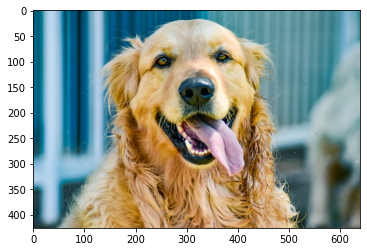

In [26]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

image_file_path = './data/goldenretriever-3724972_640.jpg'
img = Image.open(image_file_path)
print(img.size, img.mode)  # (W, H)
print(np.array(img).shape)  # (H, W, C)
plt.imshow(img)

In [12]:
from torchvision import transforms

preprocess = transforms.Compose([
    transforms.Resize(224), # 引数が1個の場合，短辺の長さが指定値になるようにアス比固定でリサイズされる
    transforms.CenterCrop(224), # 引数が1個の場合，幅，高さが指定値になるように画像中心を切り抜き
    transforms.ToTensor(), # [C,H,W]の形状になる
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

print(preprocess)

Compose(
    Resize(size=224, interpolation=bilinear, max_size=None, antialias=None)
    CenterCrop(size=(224, 224))
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)


上記のやり方は古い．今はモデルごとに前処理関数が提供されている

- https://pytorch.org/vision/stable/models.html#using-the-pre-trained-models

In [15]:
weights = models.VGG16_Weights.DEFAULT
preprocess = weights.transforms()

print(preprocess)

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


In [16]:
img_transformed = preprocess(img)  # torch.Size([3, 224, 224])

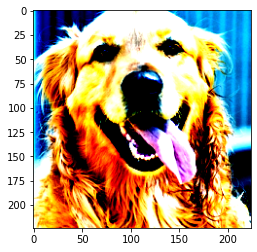

In [20]:
import numpy as np
# 検証用にノーマライズした画像を表示してみる
# [C,H,W]を[H,W,C]に変換し、0-1に値を制限
img_temp = img_transformed.numpy().transpose((1, 2, 0))
img_temp = np.clip(img_temp, 0, 1)
plt.imshow(img_temp)

### 予測

PyTorchではバッチ処理が基本なので，1枚の画像でも先頭にバッチ用の次元を追加すること

In [27]:
image_file_path = './data/goldenretriever-3724972_640.jpg'
img = Image.open(image_file_path)

img_transformed = preprocess(img)
print(f"img_transformed.shape: {img_transformed.shape}")
# バッチサイズの次元を追加
img_batch = torch.unsqueeze(img_transformed, 0)
print(f"img_batch.shape: {img_batch.shape}")

# 推論
out = net(img_batch) # バッチサイズ * クラス分類
print(f"out.shape: {out.shape}")

img_transformed.shape: torch.Size([3, 224, 224])
img_batch.shape: torch.Size([1, 3, 224, 224])
out.shape: torch.Size([1, 1000])


In [22]:
# 確率の一番高いクラスの番号を取得
idx = torch.argmax(out[0])
print(idx)
# tensor型から値を取り出し
print(idx.item())

tensor(207)
207


In [23]:
import json
# クラス番号からラベルに変換
ILSVRC_class_index = json.load(open('./data/imagenet_class_index.json', 'r'))
ILSVRC_class_index[str(idx.item())]

['n02099601', 'golden_retriever']

## 1-3: 転移学習

学習済みVGGモデルを使ってアリとハチの2値分類をするモデルを作成する

### Dataset作成

最低限以下を実装する
```python
from torch.utils.data import Dataset

class MyDataset(Dataset):
    def __getitem__(self, index):
        # インデックス index のサンプルが要求されたときに返す処理を実装
        # 訓練なら入力データと正解データのペアを返す．推論なら入力データだけでよい
        # イテレータで受け取ったものを自分で処理するので，戻り値の形式は自由

    def __len__(self):
        # データセットのサンプル数が要求されたときに返す処理を実装
```

In [60]:
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image
from pathlib import Path

class HymenopteraDataset(Dataset):
    """
    画像ファイルパスのリストを渡して，itemとして前処理した画像を返す
    """
    def __init__(self, file_list, train=True):
        self.file_list = file_list
        self.train = train
        
        resize = 224
        mean=[0.485, 0.456, 0.406]
        std=[0.229, 0.224, 0.225]

        # 推論時と同じ前処理
        preprocess_val = transforms.Compose([
            transforms.Resize(resize),
            transforms.CenterCrop(resize),
            transforms.ToTensor(),
            transforms.Normalize(mean,std),
        ])

        preprocess_train = transforms.Compose([
            # scaleの変動範囲でランダムに切り抜いてから指定の大きさにリサイズ
            # (scale=1ならリサイズされるだけ)
            transforms.RandomResizedCrop(resize, scale=(0.5,1)),
            transforms.RandomHorizontalFlip(), # ランダムに左右反転
            transforms.ToTensor(),
            transforms.Normalize(mean,std),
        ])
        
        if self.train:
            self.preprocess = preprocess_train
        else:
            self.preprocess = preprocess_val
    
    def __len__(self):
        return len(self.file_list)
    
    def __getitem__(self, index):
        img_path = self.file_list[index]
        img = Image.open(img_path)
        img_trans = self.preprocess(img)
        label = img_path.parent.name
        if label == "ants":
            label = 0
        elif label == "bees":
            label = 1
        else:
            assert False
        return img_trans, label

学習用のデータはtrainとvalでフォルダ分けされている

In [50]:
!tree ./data/hymenoptera_data -L 2

./data/hymenoptera_data
├── train
│   ├── ants
│   └── bees
└── val
    ├── ants
    └── bees

6 directories, 0 files


In [61]:
# file_listを作成
rootpath = Path("./data/hymenoptera_data/")

path_list_key = ["train", "val"]
path_list_dict = dict()

# アリとハチの画像をひとつのリストにまとめて読み込む
# 両者の区別はディレクトリ名で行う
for k in path_list_key:
    path_list = []
    for p in rootpath.glob(f"{k}/*/*.jpg"):
        path_list.append(p)
    print(f"{k}'s length: '{len(path_list)}")
    path_list_dict[k] = path_list

train's length: '243
val's length: '153


In [62]:
# ラベル名取り出すテスト
print(path_list_dict["train"][0].parent.name)
print(path_list_dict["val"][100].parent.name)

bees
ants


Datasetの動作確認
- [Pythonの __getitem__ に与える引数やスライスについて調べてみた - Qiita](https://qiita.com/gyu-don/items/bde192b129a7b1b8c532)
  - `__getitem__`はPythonの特殊メソッドのひとつで、オブジェクトに角括弧でアクセスしたときの挙動を定義できる

In [63]:
train_dataset = HymenopteraDataset(
    path_list_dict["train"],
    train = True,
)
val_dataset = HymenopteraDataset(
    path_list_dict["val"],
    train = False,
)

index = 0
img_trans, label = train_dataset[0] # __getitem__呼び出し
print(img_trans.size(), label)

torch.Size([3, 224, 224]) 1


### DataLoader作成
- https://pytorch.org/docs/stable/data.html

Datasetをバッチサイズ単位でまとめたものを返すイテレータが作成される
- 元々Tensor型のものは先頭にバッチサイズの次元が追加される
- 単純なインデックスを返すものはバッチサイズの次元になるだけ

In [86]:
from torch.utils.data import DataLoader

batch_size = 32
train_dataloader = DataLoader(
    train_dataset,
    batch_size = batch_size,
    shuffle=True,
)

val_dataloader = DataLoader(
    val_dataset,
    batch_size = batch_size,
    shuffle=False,
)

dataloaders_dict = {"train": train_dataloader, "val": val_dataloader}

# 動作確認 バッチサイズの次元が付加されたデータセットが返される
for imgs, labels in train_dataloader:
    print(imgs.size())
    print(labels.size())
    print(labels)
    break

torch.Size([32, 3, 224, 224])
torch.Size([32])
tensor([1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0,
        1, 1, 0, 1, 0, 1, 1, 0])


### 転移学習用のモデル作成

最終出力の数だけ変更する

In [66]:
from torchvision import models

weights = models.VGG16_Weights.DEFAULT
net = models.vgg16(weights=weights)

In [68]:
print(net.classifier)

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)


In [74]:
import torch

# 最後の出力層だけ変更．出力を2にする
net.classifier[6] = torch.nn.Linear(in_features=4096, out_features=2)
net.train() # 訓練モードに変更

print(net.classifier)  # print(net)で見られる情報の一部を表示

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=2, bias=True)
)


In [73]:
# 特徴量のシーケンスも単独で確認できる
# print(net.features)

### 最適化手法の設定

- https://pytorch.org/docs/stable/optim.html
  - optimizerにはiteratableなparamを入れることができるので，`net.parameters()`ですべてのパラメータを入れることもできるし，任意のパラメータのみをリスト型などにして入れることもできる

```python
# すべてのパラメータを入れる場合
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

# 特定のパラメータをリストで入れる場合
optimizer = optim.Adam([var1, var2], lr=0.0001)

# 特定のパラメータをdictで入れる(学習率を個別に上書きできる)
optim.SGD([
    {'params': model.base.parameters()},
    {'params': model.classifier.parameters(), 'lr': 1e-3}
], lr=1e-2, momentum=0.9)
```

今回はパラメータをリスト型で入れる方法を使用する．

既存のモデルのパラメータを変更する場合は`named_parameters`関数でパラメータを情報を取得し，パラメータの取得と設定を行う．

- [named_parameters](https://pytorch.org/docs/stable/generated/torch.nn.Module.html#torch.nn.Module.named_parameters)
  - パラメータ名(`features.0.weight`みたいな感じ)とパラメータをタプルで返す (パラメータだけの場合はparameters()関数を使用)
  - [パラメータ](https://pytorch.org/docs/stable/generated/torch.nn.parameter.Parameter.html)はTensor型の`data`と`requires_grad`をメンバーに持つ．`requires_grad`はデフォルトでTrueなので，勾配計算が実施される

VGG16のclassifierは0,3,6層にLinearレイヤー(パラメータを持つ層)がある

In [78]:
for name, param in net.named_parameters():
    print(name, param.data.size(), param.requires_grad)

features.0.weight torch.Size([64, 3, 3, 3]) True
features.0.bias torch.Size([64]) True
features.2.weight torch.Size([64, 64, 3, 3]) True
features.2.bias torch.Size([64]) True
features.5.weight torch.Size([128, 64, 3, 3]) True
features.5.bias torch.Size([128]) True
features.7.weight torch.Size([128, 128, 3, 3]) True
features.7.bias torch.Size([128]) True
features.10.weight torch.Size([256, 128, 3, 3]) True
features.10.bias torch.Size([256]) True
features.12.weight torch.Size([256, 256, 3, 3]) True
features.12.bias torch.Size([256]) True
features.14.weight torch.Size([256, 256, 3, 3]) True
features.14.bias torch.Size([256]) True
features.17.weight torch.Size([512, 256, 3, 3]) True
features.17.bias torch.Size([512]) True
features.19.weight torch.Size([512, 512, 3, 3]) True
features.19.bias torch.Size([512]) True
features.21.weight torch.Size([512, 512, 3, 3]) True
features.21.bias torch.Size([512]) True
features.24.weight torch.Size([512, 512, 3, 3]) True
features.24.bias torch.Size([512]

変更しないパラメータは`requires_grad`をFalseに設定しておく

In [81]:
update_param_list = []
update_param_name_list = ["classifier.6.weight", "classifier.6.bias"]

for name, param in net.named_parameters():
    if name in update_param_name_list:
        update_param_list.append(param)
    else:
        param.requires_grad = False
print(update_param_list)

[Parameter containing:
tensor([[ 0.0069,  0.0100, -0.0045,  ..., -0.0029,  0.0014,  0.0007],
        [ 0.0049, -0.0070,  0.0085,  ...,  0.0036,  0.0041,  0.0045]],
       requires_grad=True), Parameter containing:
tensor([ 0.0074, -0.0148], requires_grad=True)]


In [85]:
for name, param in net.named_parameters():
    print(name, param.data.size(), param.requires_grad)

features.0.weight torch.Size([64, 3, 3, 3]) False
features.0.bias torch.Size([64]) False
features.2.weight torch.Size([64, 64, 3, 3]) False
features.2.bias torch.Size([64]) False
features.5.weight torch.Size([128, 64, 3, 3]) False
features.5.bias torch.Size([128]) False
features.7.weight torch.Size([128, 128, 3, 3]) False
features.7.bias torch.Size([128]) False
features.10.weight torch.Size([256, 128, 3, 3]) False
features.10.bias torch.Size([256]) False
features.12.weight torch.Size([256, 256, 3, 3]) False
features.12.bias torch.Size([256]) False
features.14.weight torch.Size([256, 256, 3, 3]) False
features.14.bias torch.Size([256]) False
features.17.weight torch.Size([512, 256, 3, 3]) False
features.17.bias torch.Size([512]) False
features.19.weight torch.Size([512, 512, 3, 3]) False
features.19.bias torch.Size([512]) False
features.21.weight torch.Size([512, 512, 3, 3]) False
features.21.bias torch.Size([512]) False
features.24.weight torch.Size([512, 512, 3, 3]) False
features.24.

In [83]:
# 学習率とかのパラメータは一般的な値を使用？
optimizer = torch.optim.SGD(params=update_param_list, lr=0.001, momentum=0.9)

In [84]:
print(optimizer)

SGD (
Parameter Group 0
    dampening: 0
    foreach: None
    lr: 0.001
    maximize: False
    momentum: 0.9
    nesterov: False
    weight_decay: 0
)


optimizerの使い方は簡単

順伝搬処理 -> 損失関数計算 -> 逆伝播 -> optimizerで重み更新
```python
for input, target in dataset:
    optimizer.zero_grad()
    output = model(input)
    loss = loss_fn(output, target)
    loss.backward()
    optimizer.step()
```

### 損失関数の定義

- [CrossEntropyLoss — PyTorch 1.12 documentationCrossEntropyLoss — PyTorch 1.12 documentation](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.htmlhttps://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html)
  - 通常のクラス分類で使われる損失関数
  - softmaxを適用してからnegative log likehood lossを計算


In [77]:
criterion = torch.nn.CrossEntropyLoss()

### 学習と結果確認

`set_grad_enabled`を使うと勾配計算のフラグを全体に適用できる(個別のオプションで有効になっているものも無効にできる)
  - 参考: [PyTorchの気になるところ(GW第1弾) - Qiita: torch.no_grad()とtorch.set_grad_enabled()の違い](https://qiita.com/tatsuya11bbs/items/86141fe3ca35bdae7338)

In [92]:
# モデルを学習させる関数を作成
from tqdm import tqdm

def train_model(net, dataloaders_dict, criterion, optimizer, num_epochs):
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-------------')

        for phase in ['train', 'val']:
            if phase == 'train':
                net.train()
            else:
                net.eval()

            epoch_loss = 0.0  # epochの損失和
            epoch_corrects = 0  # epochの正解数

            # 未学習時の検証性能を確かめるため、epoch=0の訓練は省略
            if (epoch == 0) and (phase == 'train'):
                continue

            # データローダーからミニバッチを取り出すループ
            for inputs, labels in tqdm(dataloaders_dict[phase]):
                optimizer.zero_grad()

                # 順伝搬（forward）計算
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = net(inputs)
                    loss = criterion(outputs, labels)  # 損失を計算
                    _, preds = torch.max(outputs, 1)  # ラベルを予測
  
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                    epoch_loss += loss.item() * inputs.size(0)  
                    epoch_corrects += torch.sum(preds == labels.data)

            # epochごとのlossと正解率を表示
            epoch_loss = epoch_loss / len(dataloaders_dict[phase].dataset)
            epoch_acc = epoch_corrects.double() / len(dataloaders_dict[phase].dataset)
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))


In [93]:
# 学習・検証を実行する
num_epochs=2
train_model(net, dataloaders_dict, criterion, optimizer, num_epochs=num_epochs)

Epoch 1/2
-------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:15<00:00,  3.16s/it]


val Loss: 0.7835 Acc: 0.4052
Epoch 2/2
-------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:24<00:00,  3.12s/it]


train Loss: 0.4930 Acc: 0.7531


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:15<00:00,  3.10s/it]

val Loss: 0.1770 Acc: 0.9412


## 1-5: ファインチューニング

最終層だけでなく，他の層も学習パラメータを更新する

optimizerの設定を変更する以外は転移学習と同じ

In [3]:
import random
import torch
import torchvision
import numpy as np

print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

# 乱数のシードを設定
torch.manual_seed(1234)
np.random.seed(1234)
random.seed(1234)

PyTorch Version:  1.12.1+cpu
Torchvision Version:  0.13.1+cpu


### 前準備

データローダーはさっきと同じものを使用

ネットワークモデルと損失関数も同様

In [4]:
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image
from pathlib import Path

class HymenopteraDataset(Dataset):
    """
    画像ファイルパスのリストを渡して，itemとして前処理した画像を返す
    """
    def __init__(self, file_list, train=True):
        self.file_list = file_list
        self.train = train
        
        resize = 224
        mean=[0.485, 0.456, 0.406]
        std=[0.229, 0.224, 0.225]

        # 推論時と同じ前処理
        preprocess_val = transforms.Compose([
            transforms.Resize(resize),
            transforms.CenterCrop(resize),
            transforms.ToTensor(),
            transforms.Normalize(mean,std),
        ])

        preprocess_train = transforms.Compose([
            # scaleの変動範囲でランダムに切り抜いてから指定の大きさにリサイズ
            # (scale=1ならリサイズされるだけ)
            transforms.RandomResizedCrop(resize, scale=(0.5,1)),
            transforms.RandomHorizontalFlip(), # ランダムに左右反転
            transforms.ToTensor(),
            transforms.Normalize(mean,std),
        ])
        
        if self.train:
            self.preprocess = preprocess_train
        else:
            self.preprocess = preprocess_val
    
    def __len__(self):
        return len(self.file_list)
    
    def __getitem__(self, index):
        img_path = self.file_list[index]
        img = Image.open(img_path)
        img_trans = self.preprocess(img)
        label = img_path.parent.name
        if label == "ants":
            label = 0
        elif label == "bees":
            label = 1
        else:
            assert False
        return img_trans, label

In [5]:
rootpath = Path("./data/hymenoptera_data/")
path_list_key = ["train", "val"]
path_list_dict = dict()
for k in path_list_key:
    path_list = []
    for p in rootpath.glob(f"{k}/*/*.jpg"):
        path_list.append(p)
    print(f"{k}'s length: '{len(path_list)}")
    path_list_dict[k] = path_list

train's length: '243
val's length: '153


In [6]:
train_dataset = HymenopteraDataset(
    path_list_dict["train"],
    train = True,
)
val_dataset = HymenopteraDataset(
    path_list_dict["val"],
    train = False,
)

In [7]:
from torch.utils.data import DataLoader

batch_size = 32
train_dataloader = DataLoader(
    train_dataset,
    batch_size = batch_size,
    shuffle=True,
)

val_dataloader = DataLoader(
    val_dataset,
    batch_size = batch_size,
    shuffle=False,
)

dataloaders_dict = {"train": train_dataloader, "val": val_dataloader}

In [8]:
from torchvision import models
import torch

weights = models.VGG16_Weights.DEFAULT
net = models.vgg16(weights=weights)
net.classifier[6] = torch.nn.Linear(in_features=4096, out_features=2)
net.train()
print("")

In [14]:
criterion = torch.nn.CrossEntropyLoss()

### 最適化手法の設定



In [9]:
# ファインチューニングで学習させるパラメータを、変数params_to_updateの1～3に格納する
params_to_update_1 = []
params_to_update_2 = []
params_to_update_3 = []

# 学習させる層のパラメータ名を指定
update_param_names_1 = ["features"]
update_param_names_2 = ["classifier.0", "classifier.3"]
update_param_names_3 = ["classifier.6"]

for name, param in net.named_parameters():
    param.requires_grad = True
    if True in [name.find(s)==0 for s in update_param_names_1]:
        params_to_update_1.append(param)
        print("params_to_update_1に格納：", name)
    elif True in [name.find(s)==0 for s in update_param_names_2]:
        params_to_update_2.append(param)
        print("params_to_update_2に格納：", name)
    elif True in [name.find(s)==0 for s in update_param_names_3]:
        params_to_update_3.append(param)
        print("params_to_update_3に格納：", name)
    else:
        param.requires_grad = False

params_to_update_1に格納： features.0.weight
params_to_update_1に格納： features.0.bias
params_to_update_1に格納： features.2.weight
params_to_update_1に格納： features.2.bias
params_to_update_1に格納： features.5.weight
params_to_update_1に格納： features.5.bias
params_to_update_1に格納： features.7.weight
params_to_update_1に格納： features.7.bias
params_to_update_1に格納： features.10.weight
params_to_update_1に格納： features.10.bias
params_to_update_1に格納： features.12.weight
params_to_update_1に格納： features.12.bias
params_to_update_1に格納： features.14.weight
params_to_update_1に格納： features.14.bias
params_to_update_1に格納： features.17.weight
params_to_update_1に格納： features.17.bias
params_to_update_1に格納： features.19.weight
params_to_update_1に格納： features.19.bias
params_to_update_1に格納： features.21.weight
params_to_update_1に格納： features.21.bias
params_to_update_1に格納： features.24.weight
params_to_update_1に格納： features.24.bias
params_to_update_1に格納： features.26.weight
params_to_update_1に格納： features.26.bias
params_to_update_1に格納： f

In [10]:
# 最適化手法の設定
# この値に指定した理由は書かれていないが，一般的に出力層に近い方の学習率を大きめにとる
optimizer = torch.optim.SGD([
    {'params': params_to_update_1, 'lr': 1e-4},
    {'params': params_to_update_2, 'lr': 5e-4},
    {'params': params_to_update_3, 'lr': 1e-3}
], momentum=0.9)


### 学習と検証

学習用の関数も先ほどと同様

In [12]:
from tqdm import tqdm

def train_model(net, dataloaders_dict, criterion, optimizer, num_epochs):
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-------------')

        for phase in ['train', 'val']:
            if phase == 'train':
                net.train()
            else:
                net.eval()

            epoch_loss = 0.0  # epochの損失和
            epoch_corrects = 0  # epochの正解数

            if (epoch == 0) and (phase == 'train'):
                continue
            for inputs, labels in tqdm(dataloaders_dict[phase]):
                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = net(inputs)
                    loss = criterion(outputs, labels)  # 損失を計算
                    _, preds = torch.max(outputs, 1)  # ラベルを予測
  
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                    epoch_loss += loss.item() * inputs.size(0)  
                    epoch_corrects += torch.sum(preds == labels.data)

            epoch_loss = epoch_loss / len(dataloaders_dict[phase].dataset)
            epoch_acc = epoch_corrects.double() / len(dataloaders_dict[phase].dataset)
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))


In [15]:
# 学習・検証を実行する
num_epochs=2
train_model(net, dataloaders_dict, criterion, optimizer, num_epochs=num_epochs)

Epoch 1/2
-------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:16<00:00,  3.26s/it]


val Loss: 0.7702 Acc: 0.4444
Epoch 2/2
-------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [01:22<00:00, 10.31s/it]


train Loss: 0.5191 Acc: 0.7078


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:17<00:00,  3.45s/it]

val Loss: 0.1612 Acc: 0.9477


### ネットワークの保存・ロード

netオブジェクトの情報を辞書型に変換．専用のsave/load関数を使用する

In [17]:
net.state_dict().keys()

odict_keys(['features.0.weight', 'features.0.bias', 'features.2.weight', 'features.2.bias', 'features.5.weight', 'features.5.bias', 'features.7.weight', 'features.7.bias', 'features.10.weight', 'features.10.bias', 'features.12.weight', 'features.12.bias', 'features.14.weight', 'features.14.bias', 'features.17.weight', 'features.17.bias', 'features.19.weight', 'features.19.bias', 'features.21.weight', 'features.21.bias', 'features.24.weight', 'features.24.bias', 'features.26.weight', 'features.26.bias', 'features.28.weight', 'features.28.bias', 'classifier.0.weight', 'classifier.0.bias', 'classifier.3.weight', 'classifier.3.bias', 'classifier.6.weight', 'classifier.6.bias'])

In [18]:
# PyTorchのネットワークパラメータの保存
save_path = './weights_fine_tuning.pth'
torch.save(net.state_dict(), save_path)

In [19]:
# PyTorchのネットワークパラメータのロード
load_path = './weights_fine_tuning.pth'

load_weights = torch.load(load_path)

# GPU上で保存された重みをCPU上でロードする場合はオプションを追加
# load_weights = torch.load(load_path, map_location={'cuda:0': 'cpu'})

net.load_state_dict(load_weights)

<All keys matched successfully>

## GPU上で実行する場合

学習時のコードを変更するだけでよい

CPUとGPUどちらでも共通のコードを使用できる

In [ ]:
def train_model(net, dataloaders_dict, criterion, optimizer, num_epochs):
    # 初期設定
    # GPUが使えるかを確認
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("使用デバイス：", device)
    net.to(device)  # デバイスの設定

    # ネットワークがある程度固定であれば、高速化させる
    torch.backends.cudnn.benchmark = True

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-------------')

        for phase in ['train', 'val']:
            if phase == 'train':
                net.train()
            else:
                net.eval()

            epoch_loss = 0.0  # epochの損失和
            epoch_corrects = 0  # epochの正解数

            if (epoch == 0) and (phase == 'train'):
                continue
            for inputs, labels in tqdm(dataloaders_dict[phase]):
                # GPUが使えるならGPUにデータを送る (CPUなら何もしない？)
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = net(inputs)
                    loss = criterion(outputs, labels)  # 損失を計算
                    _, preds = torch.max(outputs, 1)  # ラベルを予測
  
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                    epoch_loss += loss.item() * inputs.size(0)  
                    epoch_corrects += torch.sum(preds == labels.data)

            epoch_loss = epoch_loss / len(dataloaders_dict[phase].dataset)
            epoch_acc = epoch_corrects.double() / len(dataloaders_dict[phase].dataset)
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
